<a href="https://colab.research.google.com/github/arteagac/xlogit/blob/master/examples/benchmark/google_colab_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quick Benchmark in Google Colab

This benchmark compares the estimation speed of `xlogit`, `pylogit` and `biogeme` using a dataset of artificial choices. In addition, the estimates and figures presented in the paper are resembled to a large extent by the results in this Jupyter Notebook. Make sure that a GPU Hardware Accelerator is being used by clicking `Runtime > Change runtime type`.  To run the entire benchmark simply click `Runtime > Run all`. Let's start by importing some required libraries. 
> **Important:** Google Colab may stop the execution when it detects no interaction with this page for too long. To avoid this, try to interact with this page at least every 10 minutes.

In [1]:
import pandas as pd
import numpy as np
from time import time
import sys, io

rdf = pd.DataFrame(columns=["library", "draws", "time"])  # Dataframe to save results
data_folder = "https://raw.githubusercontent.com/arteagac/xlogit/master/examples/data"

## Part 1: Run benchmark

This benchmark compares the estimation times of `xlogit`, `pylogit`, and `biogeme` at different number of random draws. The results are shown below each execution cells.

### Execute xlogit experiments

In [2]:
# Install and import xlogit
!pip install xlogit==0.1.4
from xlogit import MixedLogit
MixedLogit.check_if_gpu_available()

1 GPU device(s) available. xlogit will use GPU processing


True

In [3]:
# Prepare input data
df = pd.read_csv(data_folder+"/artificial_long.csv")  
varnames = ['price', 'time', 'conven', 'comfort', 'meals', 'petfr',
            'emipp', 'nonsig1', 'nonsig2', 'nonsig3']
X = df[varnames]
y = df['choice']
randvars = {'meals': 'n', 'petfr': 'n', 'emipp': 'n'}
alts = df['alt']
ids = df['id']

#### Run estimation using GPU

In [4]:
print("Ndraws Time(s) Log-Likeli.")
for n_draws in [100, 200, 300]:
    np.random.seed(0)
    start_time = time()
    model = MixedLogit()
    model.fit(X, y, varnames, ids=ids, alts=alts, n_draws=n_draws, verbose=0, randvars=randvars)
    ellapsed = time() - start_time
    print("{:6} {:7.2f} {:11.2f}".format(n_draws, ellapsed, model.loglikelihood))
    rdf.loc[len(rdf)] = ['xlogit_gpu', n_draws, ellapsed]

Ndraws Time(s) Log-Likeli.
   100    1.39    -2275.85
   200    2.20    -2277.51
   300    3.31    -2280.15


> **Note that the estimation takes less than 2 seconds for xlogit with GPU processing, even for 300 random draws.**

#### Run estimation without using GPU

In [5]:
from xlogit import device
device.disable_gpu_acceleration()

print("Ndraws Time(s) Log-Likeli.")
for n_draws in [100, 200, 300]:
    np.random.seed(0)
    start_time = time()
    model = MixedLogit()
    model.fit(X, y, varnames, ids=ids, alts=alts, n_draws=n_draws, verbose=0, randvars=randvars)
    ellapsed = time() - start_time
    print("{:6} {:7.2f} {:11.2f}".format(n_draws, ellapsed, model.loglikelihood))
    rdf.loc[len(rdf)] = ['xlogit', n_draws, ellapsed]

Ndraws Time(s) Log-Likeli.
   100    6.76    -2275.85
   200   12.61    -2277.51
   300   20.51    -2280.15


> **Note that withouth using a GPU, the estimation time increases.**

### Execute pylogit experiments

In [6]:
# Install and import pylogit
!pip install pylogit==0.2.2
import pylogit as pl
from collections import OrderedDict
import warnings
# Disable warnings shown by pylogit to better visualize the benchmark outputs
warnings.filterwarnings('ignore') 

     |████████████████████████████████| 184 kB 4.3 MB/s 


In [7]:
# Prepare input data
df = pd.read_csv(data_folder+"/artificial_long.csv")  
varnames = ['price', 'time', 'conven', 'comfort', 'meals', 'petfr',
            'emipp', 'nonsig1', 'nonsig2', 'nonsig3']
alt_id_col = "alt"
obs_id_col = "id"
choice_col = "choice"
mixing_id_col = "id"
mixing_vars = ["meals", "petfr", "emipp"]
spec, spec_names = OrderedDict(), OrderedDict()
for col in varnames:
    df[col] = df[col].astype(float)
    spec[col] = [[1, 2, 3]]
    spec_names[col] = [col]

# Run estimation
print("Ndraws Time(s) Log-Likeli.")
for n_draws in [100, 200, 300]:
    np.random.seed(0)
    start_time = time()
    model = pl.create_choice_model(data=df, alt_id_col=alt_id_col,
                                obs_id_col=obs_id_col, choice_col=choice_col,
                                specification=spec, mixing_vars=mixing_vars,
                                model_type="Mixed Logit", names=spec_names,
                                mixing_id_col=mixing_id_col)
    model.fit_mle(init_vals=np.zeros(len(varnames)+len(mixing_vars)),
                num_draws=n_draws, seed=123, print_res=False)
    ellapsed = time() - start_time
    print("{:6} {:7.2f} {:11.2f}".format(n_draws, ellapsed, model.log_likelihood))
    rdf.loc[len(rdf)] = ['pylogit', n_draws, ellapsed]

Ndraws Time(s) Log-Likeli.
   100   78.48    -2283.39
   200  135.76    -2285.38
   300  113.04    -2273.75


> **Note that the estimation times of `pylogit` are substantially larger compared to `xlogit` with gpu processing.**

### Execute biogeme experiments

For this experiment, `biogeme` will run using two processor cores. 

In [8]:
# Install and import biogeme
!pip install biogeme==3.2.6
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.messaging as msg
from biogeme.expressions import Beta, bioDraws, log, MonteCarlo

     |████████████████████████████████| 1.1 MB 4.2 MB/s 
     |████████████████████████████████| 235 kB 48.3 MB/s 
  Created wheel for biogeme: filename=biogeme-3.2.6-cp37-cp37m-linux_x86_64.whl size=3181713 sha256=9c3456456bfb03d0be1ff82fe993ee9b4a66c4b620b6d348ac5ef83c5b0461d7
  Stored in directory: /root/.cache/pip/wheels/68/0a/24/edcf2e1958997ca6d969b93f656546e7aef03c91aeab9dab3e
Successfully built biogeme


In [9]:
# Prepare input data
df = pd.read_csv(data_folder+"/artificial_wide.csv")
df['choice'] = df['choice'].astype('str')
mapping = {'1': 1, '2': 2, '3': 3}

for k, v in mapping.items():
    df["aval_"+k] = np.ones(df.shape[0])
df = df.replace({'choice': mapping})
database = db.Database('artificial', df)

globals().update(database.variables)

# Fixed params
b_price = Beta('b_price', 0, None, None, 0)
b_time = Beta('b_time', 0, None, None, 0)
b_conven = Beta('b_conven', 0, None, None, 0)
b_comfort = Beta('b_comfort', 0, None, None, 0)
b_nonsig1 = Beta('b_nonsig1', 0, None, None, 0)
b_nonsig2 = Beta('b_nonsig2', 0, None, None, 0)
b_nonsig3 = Beta('b_nonsig3', 0, None, None, 0)

# Random params
u_meals = Beta('u_meals', 0, None, None, 0)
u_petfr = Beta('u_petfr', 0, None, None, 0)
u_emipp = Beta('u_emipp', 0, None, None, 0)
sd_meals = Beta('sd_meals', 0, None, None, 0)
sd_petfr = Beta('sd_petfr', 0, None, None, 0)
sd_emipp = Beta('sd_emipp', 0, None, None, 0)

b_meals = u_meals + sd_meals*bioDraws('b_meals', 'NORMAL')
b_petfr = u_petfr + sd_petfr*bioDraws('b_petfr', 'NORMAL')
b_emipp = u_emipp + sd_emipp*bioDraws('b_emipp', 'NORMAL')

V1 = price_1*b_price+time_1*b_time+conven_1*b_conven+comfort_1*b_comfort+\
    meals_1*b_meals+petfr_1*b_petfr+emipp_1*b_emipp+nonsig1_1*b_nonsig1+\
        nonsig2_1*b_nonsig2+nonsig3_1*b_nonsig3
V2 = price_2*b_price+time_2*b_time+conven_2*b_conven+comfort_2*b_comfort+\
    meals_2*b_meals+petfr_2*b_petfr+emipp_2*b_emipp+nonsig1_2*b_nonsig1+\
        nonsig2_2*b_nonsig2+nonsig3_2*b_nonsig3
V3 = price_3*b_price+time_3*b_time+conven_3*b_conven+comfort_3*b_comfort+\
    meals_3*b_meals+petfr_3*b_petfr+emipp_3*b_emipp+nonsig1_3*b_nonsig1+\
        nonsig2_3*b_nonsig2+nonsig3_3*b_nonsig3

V = {1: V1, 2: V2, 3: V3}
av = {1: aval_1, 2: aval_2, 3: aval_3}

prob = models.logit(V, av, choice)
logprob = log(MonteCarlo(prob))

# Define level of verbosity
logger = msg.bioMessage()
logger.setSilent()

# Run estimation
print("Ndraws Time(s) Log-Likeli.")
for n_draws in [100, 200, 300]:
    start_time = time()
    biogeme = bio.BIOGEME(database, logprob, numberOfDraws=n_draws, numberOfThreads=2)
    biogeme.modelName = 'MixedLogitArtificial'
    biogeme.generateHtml = False
    biogeme.generatePickle = False
    results = biogeme.estimate()
    ellapsed = time() - start_time
    print("{:6} {:7.2f} {:11.2f}".format(n_draws, ellapsed, results.data.logLike))
    rdf.loc[len(rdf)] = ['biogeme', n_draws, ellapsed]

Ndraws Time(s) Log-Likeli.
   100  367.47    -2287.46
   200  658.33    -2278.40
   300 1146.12    -2276.88


> **Note that the estimation times of `biogeme` are substantially larger compared to `xlogit` with gpu processing.**

## Part 2: Plot benchmark results

In [10]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14,
                            'axes.spines.right': False,
                            'axes.spines.top': False})
markers = {'xlogit': 'x', 'xlogit_gpu': 'o', 'biogeme': 'd', 'pylogit': '^'}
colors = {'xlogit': '#ff7f00', 'xlogit_gpu': '#e41a1c', 'biogeme': '#984ea3',
           'pylogit': '#377eb8'}
libs = ['xlogit', 'xlogit_gpu' ,'biogeme', 'pylogit']

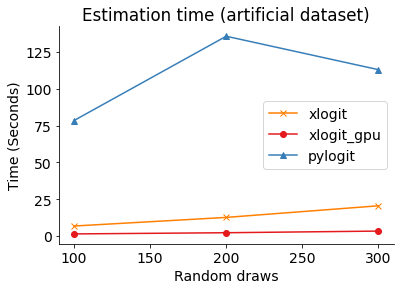

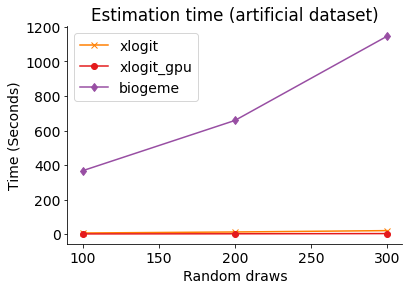

In [11]:
# Plot time benchmark
def plot_time_benchmark(plib):
    plibs = ["xlogit", "xlogit_gpu", plib]
    for i, lib in enumerate(plibs):
        d = rdf[rdf.library == lib][["draws", "time"]].values.T
        plt.plot(d[0], d[1], marker=markers[lib], c=colors[lib])
    plt.legend(plibs)
    plt.xlabel("Random draws")
    plt.ylabel("Time (Seconds)")
    plt.title("Estimation time (artificial dataset)")
    plt.show()
    plt.close()

plot_time_benchmark("pylogit")
plot_time_benchmark("biogeme")

> **These figures resemble to a large extent the results in Figures 1 and 2 in the paper**

The benchmark results indicate that `xlogit_gpu` is significantly faster than `pylogit` and `biogeme`. For instance, note that for 300 draws, `xlogit_gpu` takes less than two seconds whereas `pylogit` takes around 100 seconds. The next section presents a more convenient summary of the speed gains provided by `xlogit` in the form of a comparison table.

## Part 3: Show comparison table

In [12]:
dfc = rdf.pivot(index='library', columns='draws', values='time')

# Compute estimation time compared to xlogit_gpu
for draws in [100, 200, 300]:
    col = dfc[draws]
    dfc['c'+str(draws)] = col.values/col[col.index == "xlogit_gpu"].values
dfc['cavg'] = dfc[['c'+str(i) for i in [100, 200, 300]]].values.mean(axis=1)
dfc = dfc.round(1)

# Print in a table format
print("\n\n********* TABLE COMPARISON ESTIMATION TIME *********\n")
print("{:12} {:^23} {:^23}".format("", "Estimation time", "Compared to xlogit_gpu"))
c = dfc.columns.values
print("{:12} {:6} {:6} {:6} {:>6} {:>6} {:>6} {:>6}".format(
    "draws-->", c[0], c[1], c[2], c[3], c[4], c[5], "c_avg"))
for row in dfc.iterrows():
    c = row[1].values
    print("{:12} {:6} {:6} {:6} {:6} {:6} {:6} {:6}".format(
        row[0], c[0], c[1], c[2], c[3], c[4], c[5], c[6]))



********* TABLE COMPARISON ESTIMATION TIME *********

                 Estimation time     Compared to xlogit_gpu 
draws-->        100    200    300   c100   c200   c300  c_avg
biogeme       367.5  658.3 1146.1  263.9  299.5  345.9  303.1
pylogit        78.5  135.8  113.0   56.4   61.8   34.1   50.7
xlogit          6.8   12.6   20.5    4.9    5.7    6.2    5.6
xlogit_gpu      1.4    2.2    3.3    1.0    1.0    1.0    1.0


> **Note that this table resembles to some degree the results in Table 3 in the paper**

The first set of columns in the table summarize the different estimation times and the second set of columns compare such estimation times against the ones yielded by `xlogit_gpu`. The final column shows how slow the other tools are compared to `xlogit_gpu`. Note that, in average, `xlogit` with GPU processing is around 73x faster than `pylogit`, 467x faster than `biogeme` (which used 2 processor cores simultaneously), and 9x faster thatn `xlogit` without GPU processing. 

## Part 4: Show `xlogit` tables of estimates

The following tables show the estimates obtained with `xlogit` for the artificial, electricity, and fishing datasets.

> **Note that the estimates below are the exact same estimates for `xlogit` in the paper (Tables 1 and 2).** The results for `mlogit` can't be shown here because Google Colab does not run R code. Also, the extensive estimation times of `pylogit` make it difficult to show the complete results in this quick benchmark in Google Colab. However, the results can be entirely replicated using the mini and full benchmark.

In [13]:
device.enable_gpu_acceleration()

### SwissMetro Dataset

In [16]:
# ====== STEP 1. READ AND PRE-PROCESS DATA =====
import pandas
import numpy as np
df_wide = pandas.read_table("http://transp-or.epfl.ch/data/swissmetro.dat", sep="\t")
df_wide = df_wide[(df_wide['PURPOSE'].isin([1, 3]) \
                   & (df_wide['CHOICE'] != 0))]  # Filter samples
df_wide['custom_id'] = np.arange(len(df_wide))  # Add unique identifier
df_wide['CHOICE'] = df_wide['CHOICE'].map({1: 'TRAIN', 2: 'SM', 3: 'CAR'})

# ===== STEP 2. RESHAPE DATA TO LONG FORMAT ===== 
from xlogit.utils import wide_to_long
df = wide_to_long(df_wide, id_col='custom_id', alt_name='alt',
                  alt_list=['TRAIN', 'SM', 'CAR'], empty_val=0,
                  varying=['TT', 'CO', 'AV'], alt_is_prefix=True)

# ===== STEP 3. CREATE MODEL SPECIFICATION ===== 
df['ASC_TRAIN'] = np.ones(len(df))*(df['alt'] == 'TRAIN')
df['ASC_CAR'] = np.ones(len(df))*(df['alt'] == 'CAR')
df['TT'], df['CO'] = df['TT']/100, df['CO']/100  # Scale variables
annual_pass = (df['GA'] == 1) & (df['alt'].isin(['TRAIN', 'SM']))
df.loc[annual_pass, 'CO'] = 0  # Cost zero for pass holders

# ===== STEP 4. ESTIMATE MODEL PARAMETERS ===== 
from xlogit import MixedLogit
varnames=['ASC_CAR', 'ASC_TRAIN', 'CO', 'TT']
model = MixedLogit()
model.fit(X=df[varnames], y=df['CHOICE'], varnames=varnames,
          alts=df['alt'], ids=df['custom_id'], panels=df["ID"],
          avail=df['AV'], randvars={'TT': 'n'}, n_draws=1500)
model.summary()

GPU processing enabled.
Optimization terminated successfully.
         Current function value: 4359.218229
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
Estimation time= 2.0 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
ASC_CAR                 0.2831101     0.0564250     5.0174585      3.29e-06 ***
ASC_TRAIN              -0.5722759     0.0791059    -7.2343003      7.96e-12 ***
CO                     -1.6601672     0.0778264   -21.3316760      3.38e-78 ***
TT                     -3.2289890     0.1749384   -18.4578595      6.36e-62 ***
sd.TT                   3.6485428     0.1667409    21.8815047       2.2e-81 ***
---------------------------------------------------------------------------
Significance:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log-L

### Artificial dataset

In [14]:
import pandas
df = pd.read_csv(data_folder+"/artificial_long.csv")
varnames = ['price', 'time', 'conven', 'comfort', 'meals',
            'petfr', 'emipp', 'nonsig1', 'nonsig2', 'nonsig3']

from xlogit import MixedLogit
model = MixedLogit()
model.fit(X=df[varnames], y=df['choice'], varnames=varnames, 
          ids=df['id'], alts=df['alt'], n_draws=1500,
          randvars={'meals': 'n', 'petfr': 'n', 'emipp': 'n'})
model.summary()

GPU processing enabled.
Optimization terminated successfully.
         Current function value: 2278.801016
         Iterations: 52
         Function evaluations: 67
         Gradient evaluations: 67
Estimation time= 12.5 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
price                  -1.0320343     0.1553819    -6.6419223      2.36e-10 ***
time                   -1.4595725     0.1690836    -8.6322536      7.34e-17 ***
conven                  0.8895740     0.1413429     6.2937284      2.19e-09 ***
comfort                 1.0633392     0.1825744     5.8241414      3.68e-08 ***
meals                   1.7115916     0.1966436     8.7040298      3.99e-17 ***
petfr                   3.8752937     0.3735491    10.3742563      6.83e-24 ***
emipp                  -2.0163539     0.2139036    -9.4264592  

### Electricity dataset

In [15]:
import pandas
df = pd.read_csv(data_folder+"/electricity_long.csv")
varnames = ['pf', 'cl', 'loc', 'wk', 'tod', 'seas']

from xlogit import MixedLogit
model = MixedLogit()
model.fit(X=df[varnames], y=df['choice'], varnames=varnames,
          ids=df['chid'], panels=df['id'], alts=df['alt'], n_draws=1500,
          randvars={'pf': 'n', 'cl': 'n', 'loc': 'n', 'wk': 'n',
                    'tod': 'n', 'seas': 'n'})
model.summary()

GPU processing enabled.
Optimization terminated successfully.
         Current function value: 3886.168272
         Iterations: 40
         Function evaluations: 48
         Gradient evaluations: 48
Estimation time= 3.4 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
pf                     -1.0054499     0.0343547   -29.2667428      2.18e-96 ***
cl                     -0.2397561     0.0257748    -9.3019581      1.03e-17 ***
loc                     2.2849760     0.1245044    18.3525664      1.24e-52 ***
wk                      1.7089991     0.1009517    16.9288767      9.24e-47 ***
tod                    -9.6837120     0.3210030   -30.1670434     9.06e-100 ***
seas                   -9.8213286     0.3085359   -31.8320487     6.59e-106 ***
sd.pf                   0.2328415     0.0183764    12.6706512   

## Part 5: Fishing dataset usage example


> **This is the example presented in Section 3.3 of the paper.**

### Estimation

In [17]:
import pandas as pd
df = pd.read_csv(data_folder+"/fishing_long.csv")

from xlogit import MixedLogit
varnames = ['price', 'catch']
model = MixedLogit()
model.fit(X=df[varnames], y=df['choice'], varnames=varnames, alts=df['alt'],
          ids=df['id'], n_draws=1000, randvars={'price': 'n', 'catch': 'n'})
model.summary()

GPU processing enabled.
Optimization terminated successfully.
         Current function value: 1300.511342
         Iterations: 42
         Function evaluations: 55
         Gradient evaluations: 55
Estimation time= 1.8 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
price                  -0.0272460     0.0022981   -11.8559231      1.09e-29 ***
catch                   1.3271142     0.1743150     7.6133106      4.02e-13 ***
sd.price                0.0102129     0.0021859     4.6721638      1.59e-05 ***
sd.catch               -1.5706821     0.3762639    -4.1744167      0.000139 ***
---------------------------------------------------------------------------
Significance:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log-Likelihood= -1300.511
AIC= 2609.023
BIC= 2629.323


### Prediction

In [18]:
choices, freq = model.predict(X=df[varnames], varnames=varnames, ids=df['id'],
                              alts=df['alt'], return_freq=True, n_draws=1000)
print(f"base: {freq}")

df.loc[df['alt']=='boat', 'price'] *= 1.2  # 20 percent price increase
choices, freq = model.predict(X=df[varnames], varnames=varnames, ids=df['id'],
                              alts=df['alt'], return_freq=True, n_draws=1000)
print(f"updated: {freq}")

GPU processing enabled.
base: {'beach': 0.223, 'boat': 0.461, 'charter': 0.228, 'pier': 0.089}
GPU processing enabled.
updated: {'beach': 0.238, 'boat': 0.379, 'charter': 0.278, 'pier': 0.105}
